# Complex Network Analysis Toolkit
## Advanced Structural Characterization and Model Identification
**Autore**: Marcello Russo  
**Corso**: Complex Networks - UC3M

In [86]:
%%capture --no-display
import numpy as np
import os
import networkx as nx
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
import powerlaw
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict

# Configurazione ambiente
NETWORKS = ['net1', 'net2', 'net3', 'net4']
plt.style.use('ggplot')

## 1. Networks upload

In [12]:
def load_network(net_name: str) -> nx.Graph:
    """Carica una rete convertendo nodi a interi e rimuovendo multipli"""
    G = nx.read_pajek(f'data/{net_name}.net')
    G = nx.Graph(G)  # Converti a grafo semplice
    G = nx.convert_node_labels_to_integers(G)
    return G

# Cache per le reti
networks = {net: load_network(net) for net in tqdm(NETWORKS, desc='Loading networks')}

Loading networks:   0%|          | 0/4 [00:00<?, ?it/s]

## 2. Macroscopic Structure Analysis

In [13]:
def compute_macroscopic(G: nx.Graph) -> Dict:
    """Calcola tutte le metriche macroscopiche con ottimizzazioni"""
    # Metriche di base
    degrees = [d for _, d in G.degree()]
    
    # Analisi componente gigante
    giant = max(nx.connected_components(G), key=len)
    G_giant = G.subgraph(giant)
    
    return {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'degree_min': np.min(degrees),
        'degree_max': np.max(degrees),
        'degree_avg': np.mean(degrees),
        'clustering': nx.average_clustering(G),
        'assortativity': nx.degree_assortativity_coefficient(G),
        'avg_path_length': nx.average_shortest_path_length(G_giant),
        'diameter': nx.diameter(G_giant)
    }

with tqdm_joblib(total=len(networks), desc="Analyzing networks"):
    results = Parallel(n_jobs=-1)(delayed(compute_macroscopic)(G) for G in networks.values())

Analyzing networks:   0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
df_macro = pd.DataFrame(results, index=NETWORKS)

## 3. Microscopic Structure Analysis

In [ ]:
import os
import networkx as nx
from joblib import Parallel, delayed
from tqdm import tqdm
from typing import Dict, Tuple

# 1. Funzione per il calcolo delle centralità (versione ottimizzata con NetworkX)
def centrality_analysis(G: nx.Graph) -> Tuple[Dict[str, list], Dict[str, dict]]:
    """Calcola le centralità usando NetworkX e restituisce i top 5 nodi"""
    if len(G) == 0:
        return {}, {}

    # Calcolo delle centralità
    betweenness = nx.betweenness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G)
    degree = nx.degree_centrality(G)

    # Estrazione top 5 nodi per ogni metrica
    top_nodes = {
        'betweenness': sorted(betweenness.items(), key=lambda x: -x[1])[:5],
        'eigenvector': sorted(eigenvector.items(), key=lambda x: -x[1])[:5],
        'degree': sorted(degree.items(), key=lambda x: -x[1])[:5]
    }

    # Dati completi per eventuali analisi future
    full_data = {
        'betweenness': betweenness,
        'eigenvector': eigenvector,
        'degree': degree
    }

    return top_nodes, full_data

# 2. Generazione del report Markdown (versione robusta)
def save_to_markdown(centrality_results: dict):
    md_content = "# Centrality Analysis Results\n\n"

    # Tabella riassuntiva
    md_content += "## Summary Table\n"
    df = pd.DataFrame({
        'Network': [],
        'Betweenness (Top)': [],
        'Eigenvector (Top)': [],
        'Degree (Top)': []
    })

    for net, (top_nodes, _) in centrality_results.items():
        if not top_nodes:
            continue
            
        betweenness_top = top_nodes['betweenness'][0][1] if top_nodes['betweenness'] else 0
        eigenvector_top = top_nodes['eigenvector'][0][1] if top_nodes['eigenvector'] else 0
        degree_top = top_nodes['degree'][0][1] if top_nodes['degree'] else 0
        
        df = pd.concat([df, pd.DataFrame([{
            'Network': net,
            'Betweenness (Top)': f"{betweenness_top:.4f}",
            'Eigenvector (Top)': f"{eigenvector_top:.4f}",
            'Degree (Top)': f"{degree_top:.4f}"
        }])], ignore_index=True)

    md_content += df.to_markdown(index=False) + "\n\n"

    # Dettagli per rete
    for net, (top_nodes, _) in centrality_results.items():
        md_content += f"## Network: {net}\n"
        
        for metric in ['betweenness', 'eigenvector', 'degree']:
            md_content += f"### Top 5 Nodes by {metric.capitalize()}\n"
            md_content += "| Node | Value |\n|------|-------|\n"
            
            for node, value in top_nodes.get(metric, []):
                md_content += f"| {node} | {value:.4f} |\n"
            md_content += "\n"

    os.makedirs('reports', exist_ok=True)
    with open('reports/centrality_analysis.md', 'w') as f:
        f.write(md_content)

with tqdm(total=len(networks), desc="Analyzing networks"):
        results = Parallel(n_jobs=-1)(delayed(centrality_analysis)(G) for G in networks.values())
        centrality_results = {net: res for net, res in zip(networks.keys(), results)}

In [4]:
save_to_markdown(centrality_results)

Analyzing networks:   0%|          | 0/4 [01:00<?, ?it/s]


## 5. Net5 Analysis

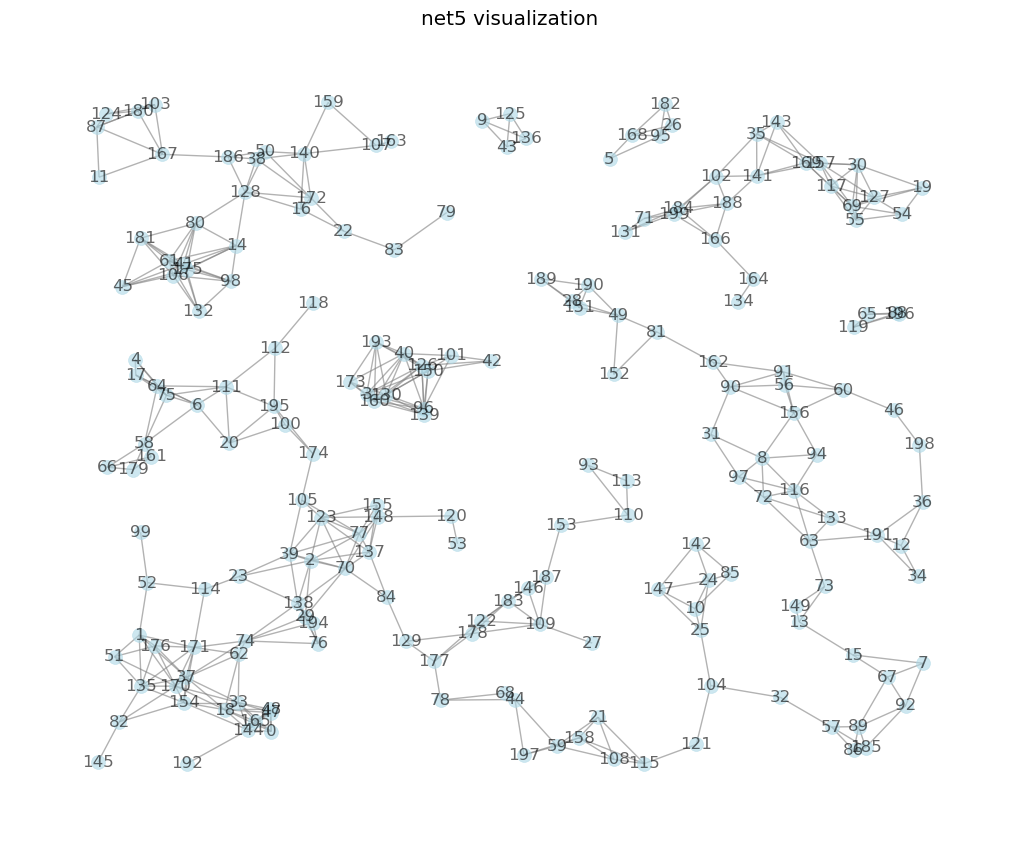

In [5]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def visualize_net5():
    """Carica e visualizza la rete spaziale net5 con le posizioni corrette."""
    # Carica la rete
    G = load_network('net5')
    
    # Carica posizioni dei nodi
    pos = np.loadtxt('data/positions_net5.txt', skiprows=1)
    pos_dict = {int(row[0]): (row[1], row[2]) for row in pos}
    
    # Disegna la rete
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos=pos_dict, with_labels=True, node_size=100, node_color='lightblue', edge_color='gray', alpha=0.6)
    
    # Mostra il grafico
    plt.title("net5 visualization")
    plt.show()

# Chiamata alla funzione
visualize_net5()

## 6. Output Generation
Generazione report e visualizzazioni

In [87]:
def generate_report():
    """Crea report completo in formato accademico"""
    # Crea le cartelle se non esistono
    os.makedirs('reports', exist_ok=True)
    os.makedirs('plots', exist_ok=True)
    
    # Controllo self-loops e archi multipli
    self_loops = {}
    multi_edges = {}
    
    for net in NETWORKS:
        G = networks[net]
        self_loops[net] = list(nx.selfloop_edges(G))  # Trova self-loops
        multi_edges[net] = [edge for edge in G.edges() if G.number_of_edges(edge[0], edge[1]) > 1]  # Trova archi multipli
    
    # Aggiungi informazioni al report
    report_content = "# Risultati Analisi Reti\n\n"
    report_content += "## Metriche Macroscopiche\n"
    report_content += df_macro.to_markdown() + "\n\n"
    
    report_content += "## Self-Loops e Archi Multipli\n"
    for net in NETWORKS:
        report_content += f"### {net}\n"
        report_content += f"- **Self-loops**: {len(self_loops[net])}\n"
        report_content += f"- **Archi multipli**: {len(multi_edges[net])}\n\n"
    
    # Salva il report
    with open('reports/final_report.md', 'w') as f:
        f.write(report_content)
    
    # Tabelle LaTeX
    df_macro.style.to_latex('reports/macro_metrics.tex', hrules=True)
    
    # Grafici
    for i in range(len(NETWORKS)):
        net = NETWORKS[i]
        G = networks[net]
        degrees = [d for _, d in G.degree()]
        max_degree = max(degrees)
        
        plt.figure()
        
        xmax = max_degree * 1.05  # 5% in più per una corretta visualizzazione
        plt.xlim(1, xmax)
        
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])  # Tick asse y fissi
        
        x_ticks = np.linspace(1, xmax, 6)  # Sei tick equidistanti tra 1 e xmax
        plt.xticks(x_ticks)
        
        # Calcolo gamma per le ultime due reti
        if i >= len(NETWORKS) - 2:
            fit = powerlaw.Fit(degrees)
            gamma = fit.power_law.alpha
            plt.title(f'Degree distribution - {net}\nGamma: {gamma:.2f}')
            powerlaw.plot_pdf(degrees, linear_bins=False, color='r')
        else:
            plt.title(f'Degree distribution - {net}')
            powerlaw.plot_pdf(degrees, linear_bins=False, color='r')
            plt.xscale('linear')  # Imposta esplicitamente la scala lineare sull'asse x
            plt.yscale('linear')  # Imposta esplicitamente la scala lineare sull'asse y
        
        plt.savefig(f'plots/{net}_degree_dist.png')
        plt.close()

In [88]:
generate_report()

Calculating best minimal value for power law fit
/opt/homebrew/Caskroom/miniforge/base/envs/cn/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
